In [303]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
import re
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')

Done!


In [304]:
# path setup
path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/20250321"
input_file_name = 'dAb34+35_slide15-new-gasket_2Ags-W+O_4p4r'
image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path, debug=False, plot_images=False, rotation=0)
# print(f'Loaded Image "{input_file_name}" {image.shape}')


In [305]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path,
    start_over=0, # if True -> ignores the pickle, and returns None for initiating with the following functions
    plot_results=False,
    debug=False
)

# scan_data = []
if not scan_data:
    start_over = True
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



Successfully loaded scan_data for "dAb34+35_slide15-new-gasket_2Ags-W+O_4p4r"


In [306]:
# todo: add a function for parameter tuning...
start_over

False

In [307]:
## Setting the parameters:
# start_over = True
do_test = 1
input_param_dict = {
    'scan_size': 5, 'assay': 'SD4', 'cAb_names': ['cAb1', 'cAb2', 'cAb3', 'cAb4','cAb5', 'cAb6', 'cAb7', 'cAb8','cAb9', 'cAb10', 'cAb11', 'cAb12','cAb13','cAb14'],
    'blur_kernel_size': 9, 'contrast_thr': 400, # preprocessing
    'canny_edge_thr1': 400, 'canny_edge_thr2': 70, 'dp': 0.7, 'param1': 20, 'param2':12, 'minRadius': 15, 'maxRadius': 21, # circle finding
    'eps': 800, 'x_power': 3, 'y_power': 5, 'min_samples': 3 # clustering
}

# reset = True/False to overwrite start_over
if start_over:
    ScanDataObj.init_or_reset_params(file_name=input_file_name, input_param_dict=input_param_dict, debug=False)
    if do_test:
        test_image = deepcopy(image)[900:1900,500:2500] #(y,x) -> change if u want!
        # checkme takes too long
        # CommonFunctions.optimize_the_params(file_name=input_file_name, input_image=test_image, how_many_times=1, plot_images=False, debug=False)
        CommonFunctions.test_current_parameters(input_image=test_image, file_name=input_file_name, fig_size=[9,9], debug=False)

In [308]:
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)

In [309]:
# start_over=True
if start_over or not scan_data.sorted_circles:
    CommonFunctions.do_initial_circle_finding(file_name=input_file_name, debug=False, plot_images=False)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
# else:
#     sorted_circles, predicted_clusters_ids = [],[]

In [310]:
# start_over = False
if start_over:
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name, debug=False, plot_blocks=1,
        # debug_block_ids=['r0c0','r0c1','r0c2','r0c3'],
        init_offset=[80,-30],
        block_size_adjustment=50,
        block_distance_adjustment=[19,55],
    )
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [311]:
# ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [312]:
# start_over = True
if start_over:
    ClassesFunctions.init_clusters_dict(scan_data.sorted_circles, scan_data.predicted_clusters_ids, input_file_name,
                                        optimize_spots_coords=True, debug=0, debug_clusters_ids=[])
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [313]:
# connect clusters and blocks (and final initiation stuff)
if start_over:
    ClassesFunctions.connect_clusters_to_blocks(file_name=input_file_name,debug=False,debug_clusters=[],debug_blocks=[],plot_images=False,)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [314]:
scan_data.get_cluster(31).__dict__

{'cluster_id': 31,
 'file_name': 'dAb34+35_slide15-new-gasket_2Ags-W+O_4p4r',
 'spots_coords_list': [[515, 557, 19],
  [565, 558, 18],
  [616, 559, 17],
  [664, 560, 19],
  [714, 562, 19]],
 'spots_coords_in_block_list': [array([135, 547,  19]),
  array([185, 548,  18]),
  array([236, 549,  17]),
  array([284, 550,  19]),
  array([334, 552,  19])],
 'avg_x': np.float64(614.8),
 'avg_y': np.float64(559.2),
 'avg_x_in_block': 234,
 'avg_y_in_block': 549,
 'avg_r': np.float64(18.4),
 'block_id': 'r0c0',
 'block_start_x': 380,
 'block_start_y': 10,
 'mean_fg_list': [np.float64(46907.28719172633),
  np.float64(50823.40212577502),
  np.float64(56088.106045589695),
  np.float64(47149.38265712013),
  np.float64(46728.318217979315)],
 'mean_bg_list': [np.float64(96.0),
  np.float64(103.0),
  np.float64(113.0),
  np.float64(109.0),
  np.float64(105.0)],
 'backup_coords_list': [[515, 557, 21],
  [565, 558, 20],
  [616, 559, 19],
  [664, 560, 21],
  [714, 562, 21]],
 'backup_block_coords_list': [a

In [315]:
# test_block.__dict__

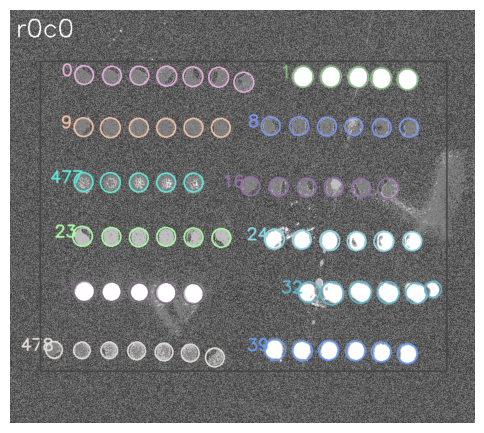

There are 12 clusters in total.


In [316]:
## Making the first template of cluster patterns
# start_over=True

test_ind = f'r0c0'
test_block: BlockObj.Block = scan_data.get_block(test_ind)
if not start_over:
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=True)
else:
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    manual_spot_edit_dict = {
        8:['change_r spot2 r-2','move spot1 2 u, 2 l','move spot2 3 r, 1 d'],
        9:['add 3 to r','add 1 cluster below d=100'],
        31:['change_r all r-2'],
        32:['add 1 to r','change_r spot-1 r-4','move spot-1 18 l, 7 u',],
        0:['change_r spot-1 r+2','add 1 cluster below d=500'],
        477:['del spot-1'],
        478:['move all 55 l, 1 d', 'change_r all r-2','move spot-2 3 r, 2 d', 'move spot-3 2 r, 1 d','change_r spot-1 r+1','move spot-1 1 d, 2 r'],
        39:['change_r all r-1'],
        24:['change_r all r-1','change_r spot0 r-1','move spot2 2 r','move spot0 1 l'],
        1:['change_r spot0 r-2']

    }
    print(test_block.clusters_ids_list)
    test_block.edit_block(debug=0, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=False, plot_images=False)
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=False)

N = len(test_block.clusters_ids_list)
print(f'There are {N} clusters in total.')


In [317]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))


fig_size = [20,10] if scan_data.assay == 'SD4' else [15,15]
print(f'start_over is {start_over}')


start_over is False


In [318]:
# ScanDataObj.get_block_image(
#             file_name=test_block.file_name,
#             block_id=test_block.block_id,
#             image_tag='block_mask'
#         )
plot_figures = False
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [319]:
# row 0
r = 0
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={'r0c0':[0,0],'r0c1':[0,0],'r0c2':[0,0],'r0c3':[2,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            3:['move spot-1 1 l','change_r all r-1','move spot2 2 l','move spot-2 2 r'],
            40:['move spot-1 9 r, 11 u','change_r spot-1 r+1','move spot-2 2 u, 2 r','change_r spot0 r-2','move spot0 2 r, 2 d',],
            479:['move all 5 r','move spot-1 30 r, 4 u'], 34:['move spot-1 10 r','change_r all r-1'], 7:['change_r spot-1 r-2'],
            44:['move spot-1 5 r, 2 u','move spot-2 2 u, 2 r','change_r spot-2 r+1'], 36:['move spot-1 3 r'], 45:['move spot-1 1 d, 2 l'],
            6:['change_r spot-1 r+2','move spot-3 3 l, 2 d','move spot-1 4 l'], 35:['change_r all r-1'],
            30:['move spot-1 2 r']
        })

['r0c0', 'r0c1', 'r0c2', 'r0c3']


In [320]:
## row 1
r = 1
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[10,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            481:['change_r all r+3'], 82:['move spot-1 10 u, 8 r',],
            48:['move spot-1 5 r, 2 u','change_r spot-4 r-2','move all 1 d, 1 r'],
            49:['change_r all r-2','move spot-1 3 r'],83:['move spot0 2 r, 2 d','change_r spot0 r-2'],
            51:['move spot-1 3 r','move spot-2 3 r'], 86:['del spot-1','move spot-1 10 r , 8 u','change_r all r-1'],
            46:['move spot-1 3 u'], 75:['change_r all r-2'],73:['change_r all r-2'],85:['change_r all r-1','move spot-1 3 r'],
            77:['move spot-1 3 d','change_r spot0 r-3','change_r spot-1 r-3'],
            47:['change_r all r-2','move spot-1 2 r'], 480:['change_r all r-2'],55:['change_r all r-1'],
            483:['move spot1 3 r, 2 u'], 50:['move spot-1 3 u, 3 r'],84:['move spot-2 4 r','move spot-1 3 r'],
            79:['move spot-1 20 l, 3 d'], 52:['del spot-2'], 484:['move spot-1 15 r, 3 u','move spot-2 8 r, 2 u'], 88:['move spot-1 3 r, 2 u','move spot-3 2 r,1 d']
        })

['r1c0', 'r1c1', 'r1c2', 'r1c3']


In [321]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            93:['change_r all r-1','change_r spot-1 r-3','change_r spot-2 r-2','move spot-1 3 l'], 109:['change_r all r-1','change_r spot0 r-2'],115:['change_r all r-2'],
            98:['change_r all r-2'], 99:['change_r all r-2'], 97:['change_r all r-2'], 94:['change_r all r-2'], 116:['change_r all r-2','move spot-1 11 r, 6 u','change_r spot-1 r-3'],
            119:['move spot-1 4 d','change_r spot-1 r+2'],105:['change_r spot0 r-3']
        })

['r2c0', 'r2c1', 'r2c2', 'r2c3']


In [322]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            137:['change_r all r-2'], 133:['change_r all r-1'],
            152:['move spot-1 5 d, 10 l'], 158:['change_r spot0 r-2'],
            146:['change_r spot-1 r-1','move spot-1 2 l'], 148:['change_r spot-1 r-1','move spot-1 2 l'],
            155:['change_r spot-1 r-3','change_r spot2 r+4','move spot2 4 l','change_r spot1 r+3','move spot1 3 d'],
            157:['move spot-1 4 d, 10 l'], 164:['del spot-1']
        })


['r3c0', 'r3c1', 'r3c2', 'r3c3']


In [323]:
# row 4
r = 4
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[-50,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r4c0', 'r4c1', 'r4c2', 'r4c3']


In [324]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[-50,0],f'r{r}c1':[-20,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r5c0', 'r5c1', 'r5c2', 'r5c3']


In [325]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[-50,0],f'r{r}c1':[-50,0],f'r{r}c2':[-50,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r6c0', 'r6c1', 'r6c2', 'r6c3']


In [326]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[-50,0],f'r{r}c1':[-50,0],f'r{r}c2':[-50,0],f'r{r}c3':[-50,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r7c0', 'r7c1', 'r7c2', 'r7c3']


In [327]:
##### row 8
r = 8
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [-50, 0], f'r{r}c1': [-50, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            299:['del'], 301:['move spot-1 4 r, 6 u'], 302:['move spot-1 4 r, 6 u']
        })


['r8c0', 'r8c1', 'r8c2', 'r8c3']


In [328]:
##### row 9
r = 9
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [-50, 0], f'r{r}c1': [-50, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            334:['move spot-1 20 r'], 337:['move spot-1 10 r, 5 u']
        })


['r9c0', 'r9c1', 'r9c2', 'r9c3']


In [329]:
##### row 10
r = 10
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [-100, 0], f'r{r}c1': [-70, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            354:['del spot0'], 360:['move spot-1 14 r, 5 u']
        })

['r10c0', 'r10c1', 'r10c2', 'r10c3']


In [330]:
##### row 11
r = 11
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [0, 0], f'r{r}c1': [0, 0], f'r{r}c2': [0, 0], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

['r11c0', 'r11c1', 'r11c2', 'r11c3']


In [331]:
# b11 = scan_data.get_block('r11c0')
# # b11.reset_block_start_end_coords((200,9900), [1200,11000], debug=False)
# # b11.add_cropped_images()
# b11.plot_block()
# b11.__dict__

In [332]:
##### row 12
r = 12
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            408:['del spot1,0,-3,-1'], 407:['move spot-1 10 r'], 675:['move all 10 l','move spot-1 20 l']
        })


['r12c0', 'r12c1', 'r12c2', 'r12c3']


In [333]:
##### row 13
r = 13
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            430:['del'], 426:['move spot-1 15 l, 7 d'], 704:['move all 7 r']
        })


['r13c0', 'r13c1', 'r13c2', 'r13c3']


In [334]:
##### row 14
r = 14
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            442:['del']
        })


['r14c0', 'r14c1', 'r14c2', 'r14c3']


In [335]:
# scan_data.get_block('r15c0').update_block_start_end_from_clusters_min_max()

In [336]:
##### row 15
r = 15
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [0, 0], f'r{r}c1': [0, -10], f'r{r}c2': [0, 0], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


['r15c0', 'r15c1', 'r15c2', 'r15c3']


In [337]:
path, input_file_name

('/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/20250321',
 'dAb34+35_slide15-new-gasket_2Ags-W+O_4p4r')

In [338]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


In [389]:
## Additional test info and labeling
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
scan_data.cAb_names = [f'cAb{x}' for x in [61,'_anti_cy5',7,4,49,31,34,33,36,35,59,55]] # row by row, left to right

# assuming scan_data.assay =='SD4':
curve_num_points = 4
num_rep = 2
num_blank_rows_at_bottom = 0

start_Ag_conc = 250
dilution_factor = 8

if curve_num_points == 4:
    rows_info = {
        'r0,2,4,6': {'Ag': 'WT'},
        'r1,3,5,7': {'Ag': 'WT'},
        'r8,10,12,14': {'Ag': 'Omicron'},
        'r9,11,13,15': {'Ag': 'Omicron'},
    }
    cols_info = {
        'col0': {'dAb': '34@1.5'},
        'col1': {'dAb': '35@1.5'},
        'col2': {'dAb': '34@1'},
        'col3': {'dAb': '35@1'},
    }
else:
    rows_info, cols_info = {}, {}

#------
blocks_info = {}
for rows_ids, ag_dict in rows_info.items():
    r_list = [int(x) for x in re.findall(r'\d+', rows_ids)]
    if len(r_list) != curve_num_points:
        print('WTF!!!')

    for col, dAb_dict in cols_info.items():
        c = int(re.findall(r'\d+', col)[0])

        point_counter = 0
        for r in r_list:
            block_id = f'r{r}c{c}'
            block = scan_data.get_block(block_id)
            block.dAb_label = dAb_dict['dAb']
            block.target = ag_dict['Ag']
            block.Ag_conc = start_Ag_conc / (dilution_factor ** point_counter)
            block.add_names_to_clusters(debug=0)
            print(f'{block.block_id} - {block.target}@{block.Ag_conc} - {block.dAb_label}')
            point_counter += 1

# def add_labels(assay_info_dict,debug=False):
#     blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
#     CommonFunctions.debug_report(f'blank_rows are {blank_rows}',debug)
#     for start_block_id, cond_dict in assay_info_dict.items():
#         start_block = scan_data.get_block(start_block_id)
#
#         for n in range(1,curve_num_points):
#             new_r = start_block.row_number + n
#             new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
#             new_block.dAb_label = cond_dict['dAb']
#             new_block.target = cond_dict['Ag']
#             new_block.Ag_conc = start_Ag_conc / dilution_factor ** n if new_r not in blank_rows else 0
#             new_block.add_names_to_clusters(debug=debug)
#             print(f'\t{new_block.block_id} - {new_block.target}@{new_block.Ag_conc}')
#
# add_labels(assay_info_dict=assay_info, debug=0)



r0c0 - WT@250.0 - 34@1.5
r2c0 - WT@31.25 - 34@1.5
r4c0 - WT@3.90625 - 34@1.5
r6c0 - WT@0.48828125 - 34@1.5
r0c1 - WT@250.0 - 35@1.5
r2c1 - WT@31.25 - 35@1.5
r4c1 - WT@3.90625 - 35@1.5
r6c1 - WT@0.48828125 - 35@1.5
r0c2 - WT@250.0 - 34@1
r2c2 - WT@31.25 - 34@1
r4c2 - WT@3.90625 - 34@1
r6c2 - WT@0.48828125 - 34@1
r0c3 - WT@250.0 - 35@1
r2c3 - WT@31.25 - 35@1
r4c3 - WT@3.90625 - 35@1
r6c3 - WT@0.48828125 - 35@1
r1c0 - WT@250.0 - 34@1.5
r3c0 - WT@31.25 - 34@1.5
r5c0 - WT@3.90625 - 34@1.5
r7c0 - WT@0.48828125 - 34@1.5
r1c1 - WT@250.0 - 35@1.5
r3c1 - WT@31.25 - 35@1.5
r5c1 - WT@3.90625 - 35@1.5
r7c1 - WT@0.48828125 - 35@1.5
r1c2 - WT@250.0 - 34@1
r3c2 - WT@31.25 - 34@1
r5c2 - WT@3.90625 - 34@1
r7c2 - WT@0.48828125 - 34@1
r1c3 - WT@250.0 - 35@1
r3c3 - WT@31.25 - 35@1
r5c3 - WT@3.90625 - 35@1
r7c3 - WT@0.48828125 - 35@1
r8c0 - Omicron@250.0 - 34@1.5
r10c0 - Omicron@31.25 - 34@1.5
r12c0 - Omicron@3.90625 - 34@1.5
r14c0 - Omicron@0.48828125 - 34@1.5
r8c1 - Omicron@250.0 - 35@1.5
r10c1 - Omicron@

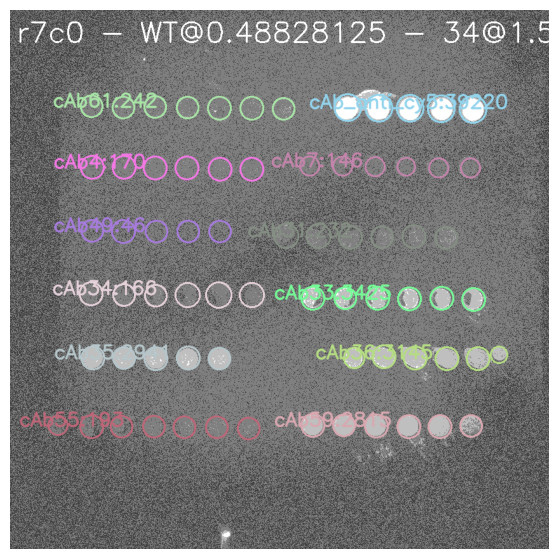

In [390]:
scan_data.get_block('r7c0').plot_block(description='full_report')


In [391]:
# ClassesFunctions.save_dicts_in_pickle(path=path)

In [392]:
# scan_data.get_block('r0c0').full_report()
# print(scan_data.get_block('r0c0').full_report(return_str=1))
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [393]:
out_dfs = []
sigma1 = 2
sigma2 = 1.7

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



r0c0 ....
r0c1 ....
r0c2 ....
r0c3 ....
delete1: 3239 (3.1768%), delete2: 5992 (5.8769%) -> total delete: 9.05%
r1c0 ....
r1c1 ....
r1c2 ....
r1c3 ....
delete1: 4409 (4.2870%), delete2: 10035 (9.7573%) -> total delete: 14.04%
r2c0 ....
r2c1 ....
r2c2 ....
r2c3 ....
delete1: 2826 (2.7628%), delete2: 9595 (9.3805%) -> total delete: 12.14%
r3c0 ....
r3c1 ....
r3c2 ....
r3c3 ....
delete1: 1146 (1.1197%), delete2: 9547 (9.3279%) -> total delete: 10.45%
r4c0 ....
r4c1 ....
r4c2 ....
r4c3 ....
delete1: 3332 (3.2583%), delete2: 7304 (7.1425%) -> total delete: 10.40%
r5c0 ....
r5c1 ....
r5c2 ....
r5c3 ....
delete1: 2148 (2.1084%), delete2: 9747 (9.5674%) -> total delete: 11.68%
r6c0 ....
r6c1 ....
r6c2 ....
r6c3 ....
delete1: 2113 (2.1375%), delete2: 10622 (10.7452%) -> total delete: 12.88%
r7c0 ....
r7c1 ....
r7c2 ....
r7c3 ....
delete1: 5280 (5.3387%), delete2: 6396 (6.4671%) -> total delete: 11.81%
r8c0 ....
r8c1 ....
r8c2 ....
r8c3 ....
delete1: 3158 (3.0855%), delete2: 7189 (7.0239%) -> to

In [394]:
path

'/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/20250321'

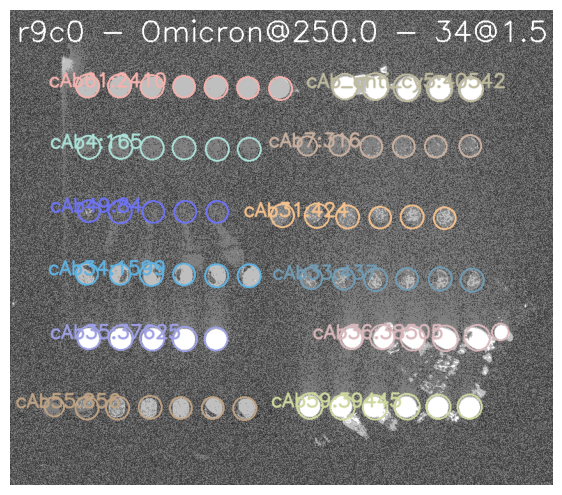

,Block_ID,Col,Row,Ag_Conc.,target,dAb_name,cAb_name,Cluster_ID,Spot_Index,F,B,F_B,F_B_PostProcess,Average_F_B_PostProcess
18,r9c0,0,9,250.0,Omicron,34@1.5,cAb4,602,0,231,94,137,137.410097,165.277384
19,r9c0,0,9,250.0,Omicron,34@1.5,cAb4,602,1,255,97,158,158.532329,165.277384
20,r9c0,0,9,250.0,Omicron,34@1.5,cAb4,602,2,271,96,175,175.732507,165.277384
21,r9c0,0,9,250.0,Omicron,34@1.5,cAb4,602,3,291,98,193,193.290523,165.277384
22,r9c0,0,9,250.0,Omicron,34@1.5,cAb4,602,4,276,97,179,179.572188,165.277384
23,r9c0,0,9,250.0,Omicron,34@1.5,cAb4,602,5,244,97,147,147.126661,165.277384


In [395]:
# wanna see everything for Z in rXcY:
cAb = 'cAb4'
row_id = 9
block_id = f'r{row_id}c0'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='full_report', crop_to_mask=1)
# print(df)
df

In [396]:
# formated_path

In [425]:
dosave=True
formated_path = f'{path}/{input_file_name}_scan_values'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

saved intensities_df (4569, 14).


,Block_ID,Col,Row,Ag_Conc.,target,dAb_name,cAb_name,Cluster_ID,Spot_Index,F,B,F_B,F_B_PostProcess,Average_F_B_PostProcess
0,r0c0,0,0,250.000000,WT,34@1.5,cAb61,0,0,376,91,285,285.328048,289.205623
1,r0c0,0,0,250.000000,WT,34@1.5,cAb61,0,1,403,92,311,311.812686,289.205623
2,r0c0,0,0,250.000000,WT,34@1.5,cAb61,0,2,436,92,344,NaN,289.205623
3,r0c0,0,0,250.000000,WT,34@1.5,cAb61,0,3,391,91,300,300.024801,289.205623
4,r0c0,0,0,250.000000,WT,34@1.5,cAb61,0,4,346,92,254,254.574845,289.205623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4564,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,1,161,83,78,78.989098,73.782840
4565,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,2,167,84,83,83.120977,73.782840
4566,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,3,158,93,65,65.525273,73.782840
4567,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,4,208,100,108,NaN,73.782840


In [426]:
intensities_df[intensities_df['cAb_name']=='cAb55']

,Block_ID,Col,Row,Ag_Conc.,target,dAb_name,cAb_name,Cluster_ID,Spot_Index,F,B,F_B,F_B_PostProcess,Average_F_B_PostProcess
64,r0c0,0,0,250.000000,WT,34@1.5,cAb55,478,0,544,91,453,453.063990,710.168453
65,r0c0,0,0,250.000000,WT,34@1.5,cAb55,478,1,735,93,642,642.988708,710.168453
66,r0c0,0,0,250.000000,WT,34@1.5,cAb55,478,2,989,92,897,897.323714,710.168453
67,r0c0,0,0,250.000000,WT,34@1.5,cAb55,478,3,931,99,832,832.756937,710.168453
68,r0c0,0,0,250.000000,WT,34@1.5,cAb55,478,4,970,102,868,868.806881,710.168453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4564,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,1,161,83,78,78.989098,73.782840
4565,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,2,167,84,83,83.120977,73.782840
4566,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,3,158,93,65,65.525273,73.782840
4567,r15c3,3,15,0.488281,Omicron,35@1,cAb55,783,4,208,100,108,NaN,73.782840


In [427]:
# # to see what has been deleted.....
# subset = intensities_df[intensities_df['F_B_PostProcess'].isnull()]
#
# block_cab_pairs = set(zip(subset['Block_ID'], subset['cAb_name']))
#
# filtered_df = intensities_df[
#     intensities_df[['Block_ID', 'cAb_name']].apply(tuple, axis=1).isin(block_cab_pairs)
# ]
# print(block_cab_pairs)
# print(filtered_df.shape)
# filtered_df


In [428]:
# grouped = intensities_df.groupby(['Row', 'Col', 'cAb_name','target', 'Ag_Conc.', 'Block_ID']) ['Average_F_B_PostProcess'].mean().reset_index()
# grouped = grouped.sort_values(by=['Row', 'Col'])
#
#
# grouped
#


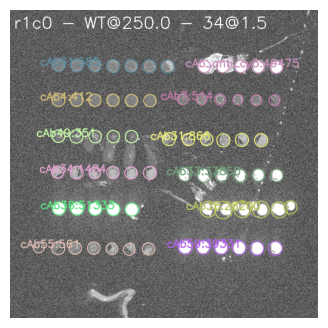

In [429]:
scan_data.get_block('r1c0').plot_block(description='full_report', fig_size=[4,4])


In [430]:
grouped = intensities_df.groupby(['Ag_Conc.', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])

if num_rep == 2 and curve_num_points==4:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 else "1"), axis=1)

grouped[grouped['cAb_name']=='cAb55']



,Ag_Conc.,Row,Col,target,cAb_name,dAb_name,Average_F_B_PostProcess,dAb_cAb_rep
583,250.000000,0,0,WT,cAb55,34@1.5,710.168453,34@1.5_cAb55_0
595,250.000000,0,1,WT,cAb55,35@1.5,1669.442629,35@1.5_cAb55_0
607,250.000000,0,2,WT,cAb55,34@1,1192.176545,34@1_cAb55_0
619,250.000000,0,3,WT,cAb55,35@1,851.321205,35@1_cAb55_0
631,250.000000,1,0,WT,cAb55,34@1.5,561.919629,34@1.5_cAb55_1
...,...,...,...,...,...,...,...,...
139,0.488281,14,3,Omicron,cAb55,35@1,93.508981,35@1_cAb55_0
151,0.488281,15,0,Omicron,cAb55,34@1.5,98.797638,34@1.5_cAb55_1
163,0.488281,15,1,Omicron,cAb55,35@1.5,610.970788,35@1.5_cAb55_1
175,0.488281,15,2,Omicron,cAb55,34@1,92.194536,34@1_cAb55_1


In [431]:
results_df = grouped.pivot_table(index=['target','Ag_Conc.'], columns=['dAb_cAb_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by=['target','Ag_Conc.'],ascending=False)
print(results_df.shape)
results_df


(8, 96)


dAb_cAb_rep         34@1.5_cAb31_0  34@1.5_cAb31_1  34@1.5_cAb33_0  \
target  Ag_Conc.                                                     
WT      250.000000      438.210558      866.615504    38297.199917   
        31.250000       948.800194      614.738647    28611.312468   
        3.906250        514.240394      349.835778    13088.413225   
        0.488281        272.202054      232.759193     3461.584942   
Omicron 250.000000      440.587060      424.509473      559.035336   
        31.250000       381.385960      267.510860      308.619398   
        3.906250        199.168942      174.283890      181.922759   
        0.488281        142.486188      136.379456      977.199418   

dAb_cAb_rep         34@1.5_cAb33_1  34@1.5_cAb34_0  34@1.5_cAb34_1  \
target  Ag_Conc.                                                     
WT      250.000000    33850.329278     1609.236663     1484.683598   
        31.250000     30856.256161      511.144152      487.676215   
        3.906250      11470.481445      271.789676      211.169211   
        0.488281       3425.229407      183.904721      166.330461   
Omicron 250.000000      437.116373     1361.851556     1599.367518   
        31.250000       236.562222      563.933745      457.544347   
        3.906250        165.778370      393.619390      327.028825   
        0.488281        797.479820      132.236406      125.891627   

dAb_cAb_rep         34@1.5_cAb35_0  34@1.5_cAb35_1  34@1.5_cAb36_0  \
target  Ag_Conc.                                                     
WT      250.000000    39183.663165    28200.377395    47798.847548   
        31.250000     47774.994301    36809.565766    40172.293224   
        3.906250       7059.288701     6113.551488    10973.109810   
        0.488281       1903.777723     2941.287696     2860.853818   
Omicron 250.000000    38897.100597    37625.941624    42414.282889   
        31.250000     15851.726319     9923.646669    17751.619761   
        3.906250       1457.426519     2083.359745     4329.223870   
        0.488281        503.426324      163.240351      682.317033   

dAb_cAb_rep         34@1.5_cAb36_1  ...  35@1_cAb55_0  35@1_cAb55_1  \
target  Ag_Conc.                    ...                               
WT      250.000000    51333.821435  ...    851.321205  39842.908747   
        31.250000     38672.217063  ...  11647.104627    200.269837   
        3.906250      10841.793728  ...    124.609522    118.137769   
        0.488281       3145.056606  ...    144.438178    135.592479   
Omicron 250.000000    38505.768196  ...  36188.426924  35234.062159   
        31.250000     19989.167598  ...    206.729433    129.260105   
        3.906250       4390.157933  ...     89.370340     92.892256   
        0.488281        323.374025  ...     93.508981     73.782840   

dAb_cAb_rep         35@1_cAb59_0  35@1_cAb59_1  35@1_cAb61_0  35@1_cAb61_1  \
target  Ag_Conc.                                                             
WT      250.000000  44814.187174    897.368102  42055.079600  44381.211142   
        31.250000     188.409800  12676.264391  40287.673080  34962.224282   
        3.906250     2292.243739   2072.158150  13375.870046  12597.911805   
        0.488281      801.174491    798.182411   2195.647100   3020.189180   
Omicron 250.000000   1784.277553    781.317076  43864.430939  43299.733445   
        31.250000   14735.148739  15102.392424  37214.338902  35280.603458   
        3.906250     3908.603238   3454.549884  10004.990961   9671.086300   
        0.488281      907.144150    819.072844   2439.832064   2200.819130   

dAb_cAb_rep         35@1_cAb7_0  35@1_cAb7_1  35@1_cAb_anti_cy5_0  \
target  Ag_Conc.                                                    
WT      250.000000   473.560227   618.025333         42868.461363   
        31.250000    162.385599  2883.774994         50744.936984   
        3.906250     366.294582   277.153868         40784.394899   
        0.488281      88.315501    88.036762         41046.8

In [434]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

formated_path = f'{path}/{input_file_name}_summary'
results_writer = pd.ExcelWriter(formated_path + '.xlsx')
results_df.to_excel(results_writer, index=True)
results_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(results_df, file)
